In [1]:
import pyarrow.parquet as pq
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from scipy import fftpack
import warnings
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import collections
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn.feature_selection import RFE, GenericUnivariateSelect
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE

warnings.simplefilter('ignore')
print(os.listdir("../input"))

Using TensorFlow backend.


['test.parquet', 'sample_submission.csv', 'metadata_train.csv', 'train.parquet', 'metadata_test.csv']


In [2]:
#id_measurement: the ID code for a trio of signals recorded at the same time.
#signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test,
#so the first ID in train is '0' but the first ID in test is '8712'.
#phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.
#target: 0 if the power line is undamaged, 1 if there is a fault.
#From the Pictures Below , Found that this is imbalanced data.

Text(0.5,1,'the number of target in different phase')

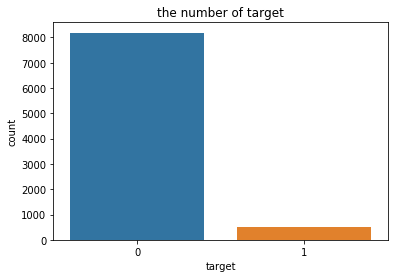

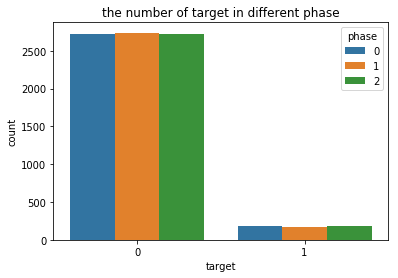

In [3]:
m_train = "../input/metadata_train.csv"
par_train = "../input/train.parquet"

meta_train = pd.read_csv(m_train)
meta_train = meta_train.set_index('id_measurement')

plt.figure()
sns.countplot(x='target', data=meta_train) 
plt.title('the number of target')

plt.figure()
sns.countplot(x='target', hue='phase', data=meta_train)
plt.title('the number of target in different phase')

In [4]:
#The signal data. Each column contains one signal; 800,000 int8 measurements as exported with
pf_train = pq.read_pandas(par_train)
pf_train = pf_train.to_pandas()
pf_train = pf_train.T #Turn columns into the rows

In [5]:
#Because of Out of memory , del original data
pf_train_v = pf_train.values

del pf_train
gc.collect()

17452

In [6]:
#Normalize Data to (-1,1)
def min_max(x, min=-128, max=127, range_needed=(-1, 1)):
    norm = (x+abs(min))/(max+abs(min))
    return norm * (range_needed[1] + abs(range_needed[0])) + range_needed[0]

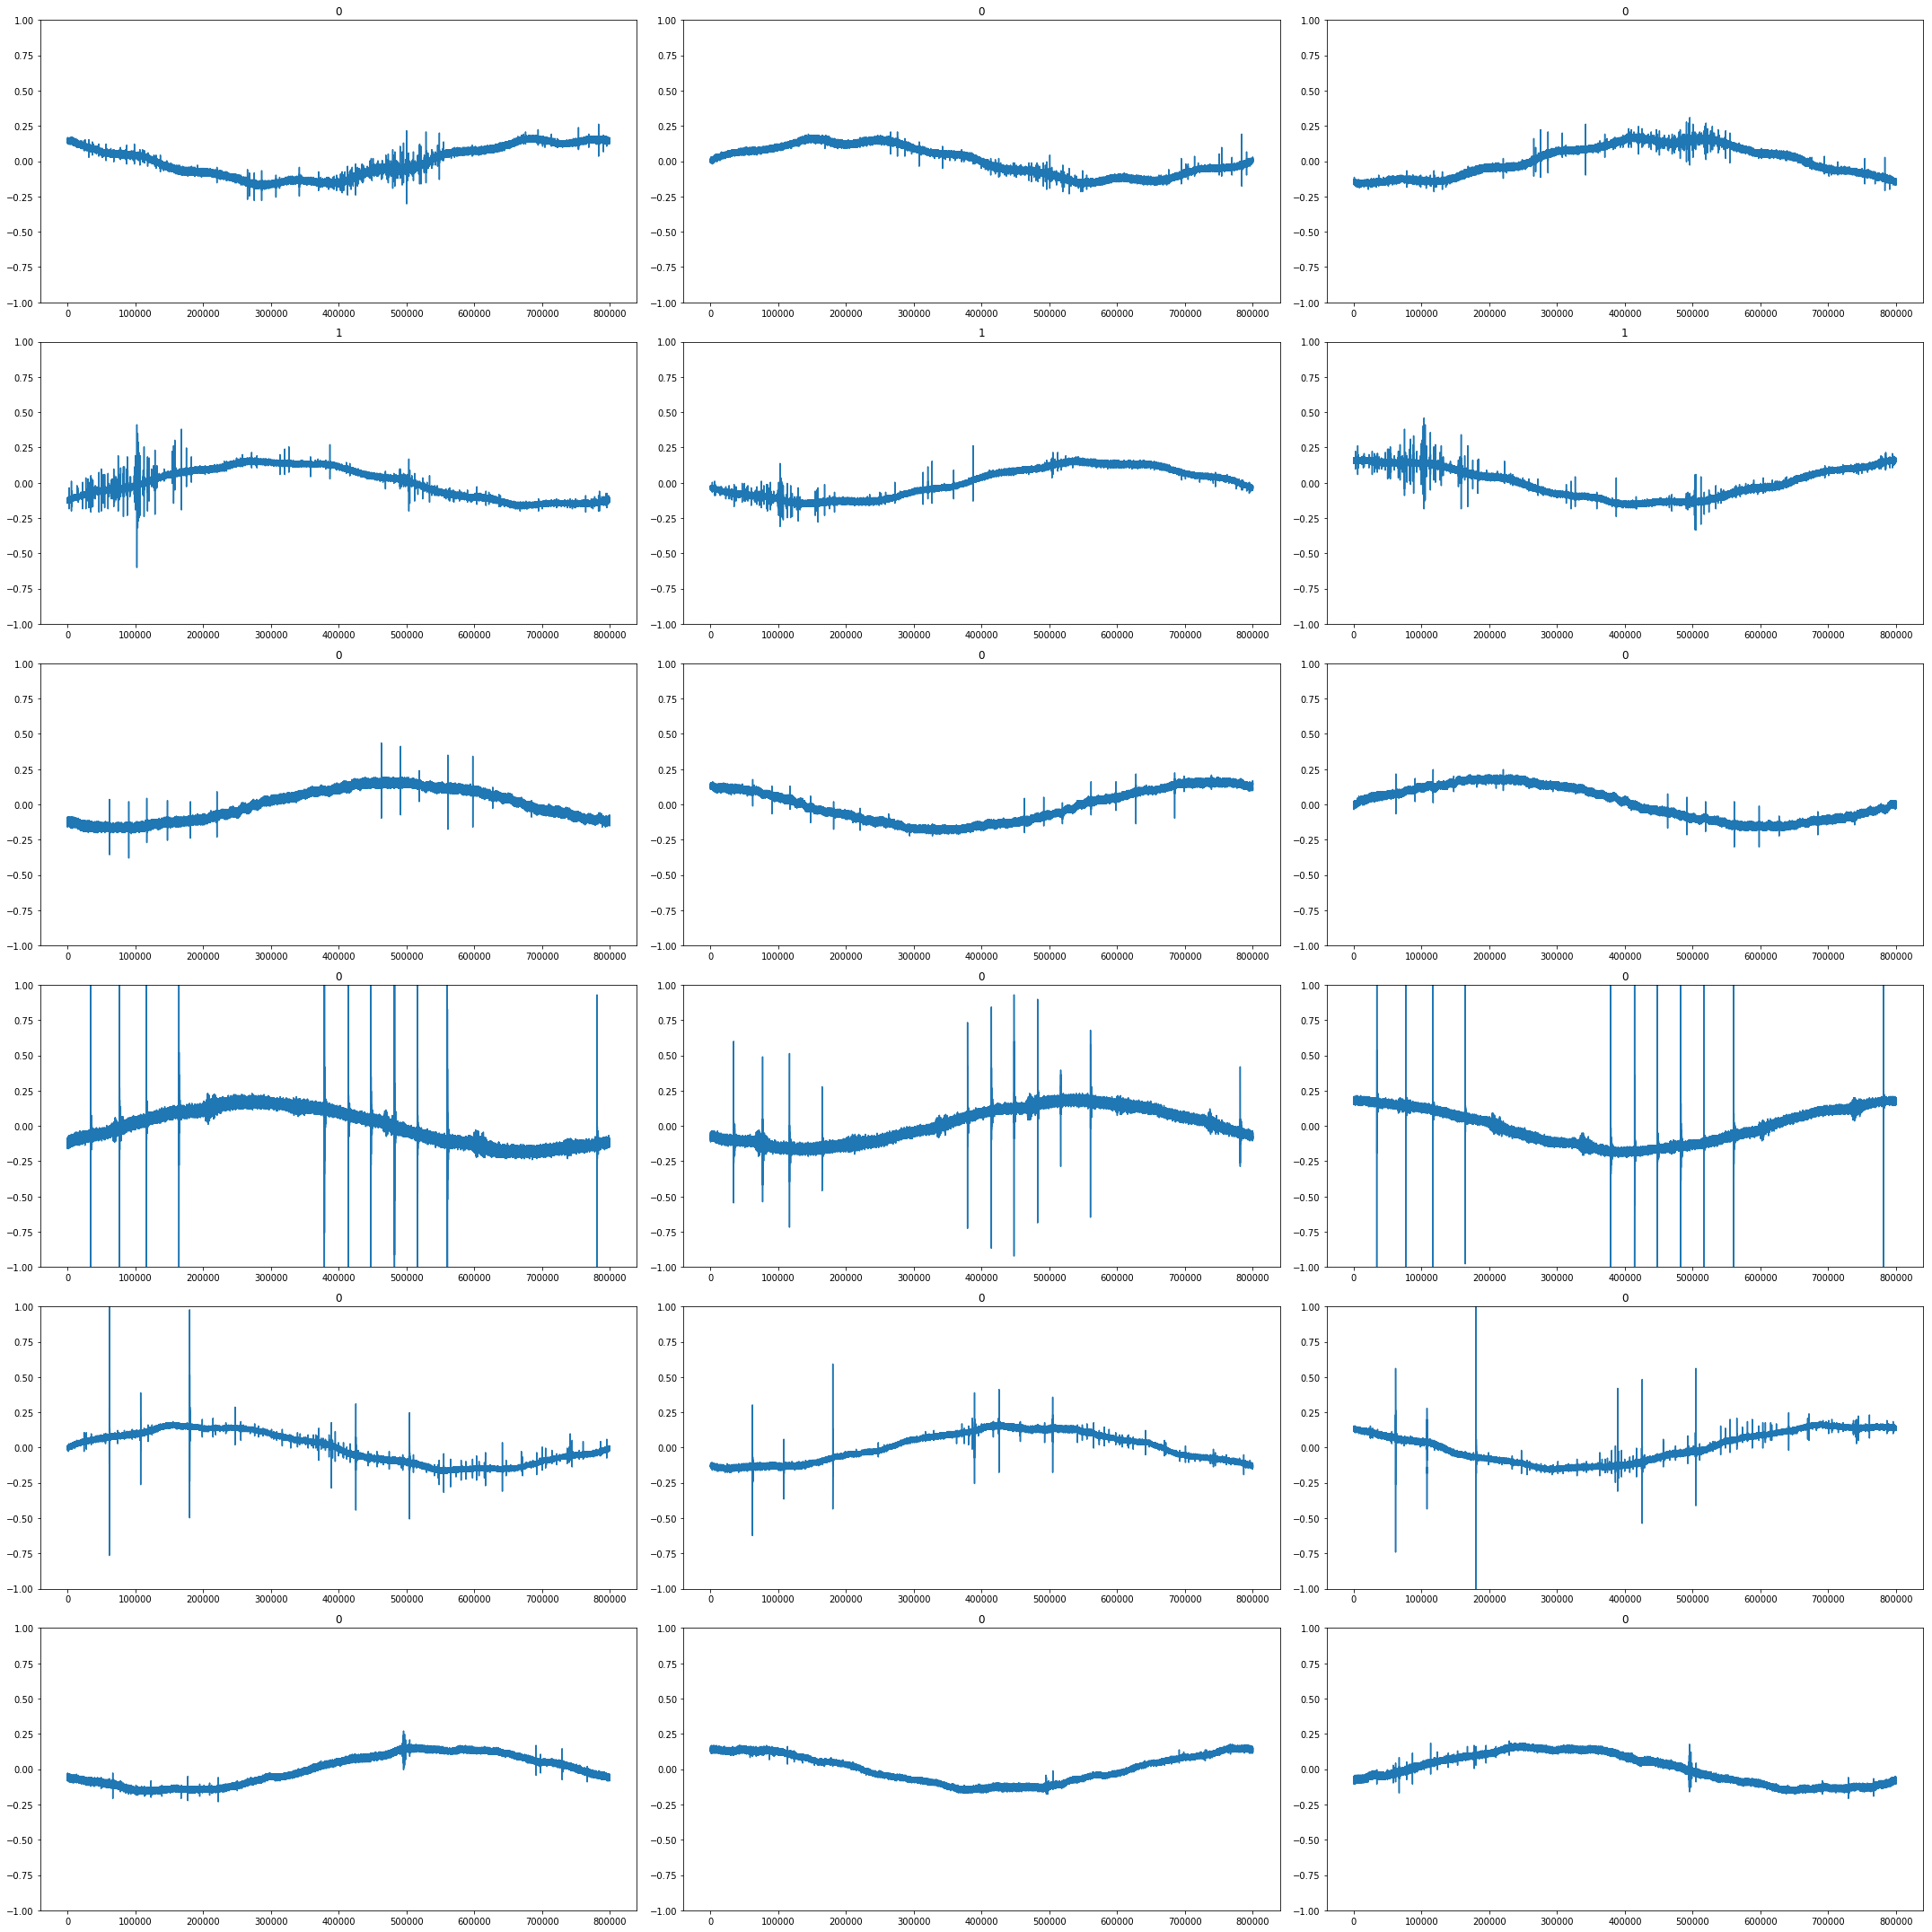

In [7]:
x = pf_train_v[:18, :]
targets = meta_train.target.values[:18]
x = min_max(x)

def p_fig(data, target, n_rows=None, size=180):
    assert len(target) % 3 == 0
    if n_rows == None:
        n_rows = int(len(target) / 3)        
    fig, axes = plt.subplots(n_rows, 3, figsize=(int(size/n_rows), int(size/n_rows)))
    axes = axes.flatten()
    for i, (ax, t) in enumerate(zip(axes, target)):
        ax.plot(data[i, :])
        ax.set_title(t)
        ax.set_ylim(bottom=-1.0, top=1.0)
    fig.tight_layout()

p_fig(x, targets)

In [8]:
#Make Ware Sort
#To Calculate How Many Waves has Occured in a phase

class WaveArraySort(object):
    
    def __init__(self):
        self.wavebegin = 0
        self.waveend   = 0
    
    def findWaveAndSort(self, data):
        
        self.orignalArray = data
        self.waveArray    = []
        waveDown          = False
        waveraise         = False
        reachingend       = False
        i = 0
        
        while (i <= (self.orignalArray.shape[0] - 2)):
            
            if (self.orignalArray[i] > self.orignalArray[i+1]): waveDown = True    
            if self.orignalArray[i] < self.orignalArray[i+1]: waveraise = True
            if (i + 1 == self.orignalArray.shape[0] - 1): reachingend = True
                
            if (waveDown == True and (waveraise or reachingend)):
                if reachingend:
                    self.waveend = i+1
                else:
                    self.waveend = i
                
                self.sortwave()
                self.wavebegin = i+1
                waveDown = False
                waveraise = False
            
            i +=1
        
        return self.waveArray    
    
    def sortwave(self):
        
        p     = self.wavebegin
        begin = self.wavebegin
        end   = self.waveend
        wave  = []
        
        while begin <= end:
            wave.append(self.orignalArray[begin])
            begin +=1
        
        self.waveArray.append(wave)

**Frequency:**

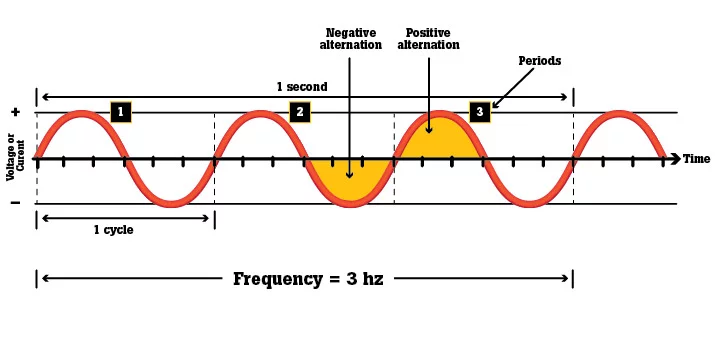

In [9]:
#In order to pick up the features of Fault Data 

period     = 0.02
time_step  = 0.02 / 800000
time_vec   = np.arange(0, 0.02, time_step)
f_sampling = 1 / time_step
print(f'Sampling Frequency = {f_sampling / 1e6} MHz')

sample_freq = fftpack.fftfreq(800000, d=time_step)
pidxs       = np.where(sample_freq > 0)
freqs       = sample_freq[pidxs]

def FourierTransform(sig):
    
    sig_fft = fftpack.fft(sig)
    power   = np.abs(sig_fft)[pidxs]
    
    return power, sig_fft

#Just Test
bad_sig                      = min_max(pf_train_v[3, :]) 
good_sig                     = min_max(pf_train_v[1, :])
good_sig_power, good_sig_fft = FourierTransform(good_sig)
bad_sig_power,  bad_sig_fft  = FourierTransform(bad_sig)

Sampling Frequency = 40.0 MHz


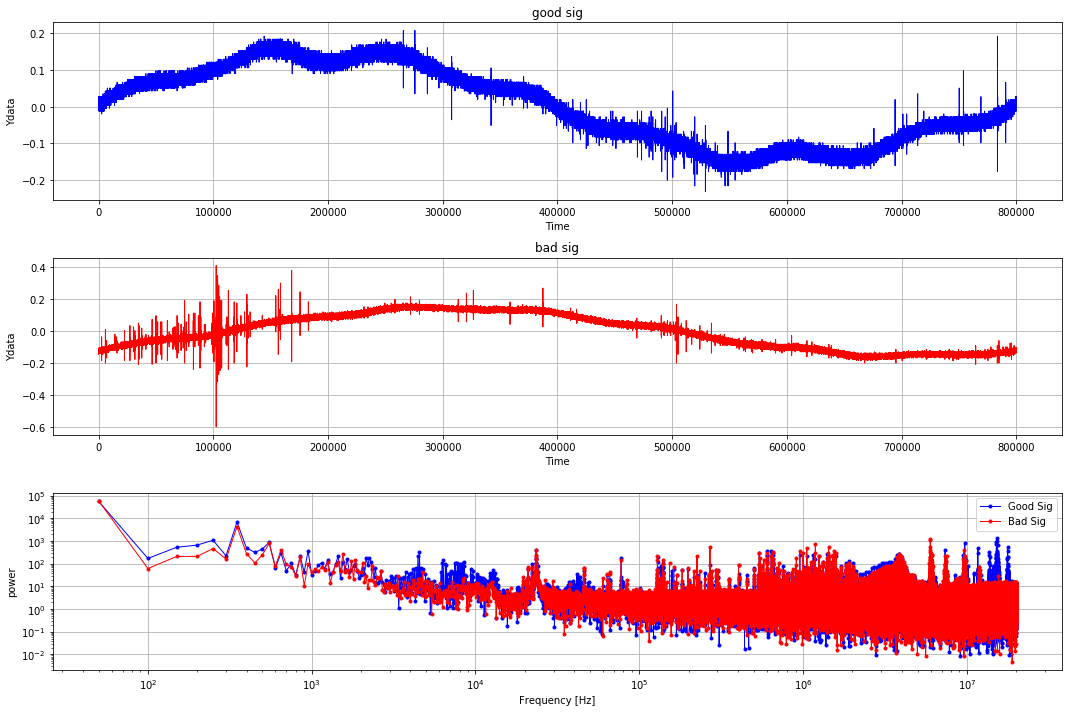

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(good_sig,'b-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Ydata')
plt.title('good sig')
plt.grid(True)

plt.subplot(312)
plt.plot(bad_sig,'r-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Ydata')
plt.title('bad sig')
plt.grid(True)

plt.subplot(313)
#plt.semilogx(freqs, power,'b.-',lw=1)
plt.loglog(freqs, good_sig_power,'b.-',lw=1, label='Good Sig')
plt.loglog(freqs, bad_sig_power,'r.-',lw=1, label='Bad Sig',)
plt.xlabel('Frequency [Hz]')
plt.ylabel('power')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)

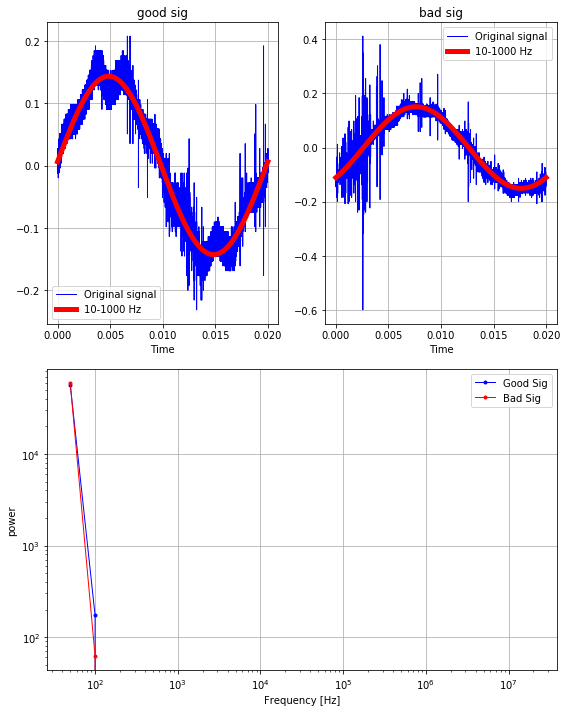

In [11]:
#Denosizng
#The idea is From:
#https://www.kaggle.com/zoujie/analyze-power-line-signals-like-a-physicist
#Use Bandpassfilter to exclude low frequency
def bandpassfilter(spec, sample_freq, lowcut, highcut):
    # a digital bandpass filter with a infinite roll off. 
    # Note that we will keep the frequency point right at low cut-off and high cut-off frequencies. 
    spec1 = spec.copy()
    spec1[np.abs(sample_freq) < lowcut] = 0
    spec1[np.abs(sample_freq) > highcut] = 0
    filtered_sig = fftpack.ifft(spec1) #reversed fft
    
    return filtered_sig, spec1

lowcut, highcut   = 10, 100
filter_bad_sig,  filter_bad_power  = bandpassfilter(bad_sig_fft, sample_freq, lowcut, highcut)
filter_good_sig, filter_good_power = bandpassfilter(good_sig_fft, sample_freq, lowcut, highcut)
freqs             = sample_freq[pidxs]
filter_bad_power  = np.abs(filter_bad_power)[pidxs]
filter_good_power = np.abs(filter_good_power)[pidxs]

plt.figure(figsize=(8,10))
plt.subplot(221)
plt.plot(time_vec, good_sig,'b-', linewidth=1 ,label='Original signal')
plt.plot(time_vec, filter_good_sig,'r-', linewidth=5 ,label='10-1000 Hz')
plt.xlabel('Time')
plt.title('good sig')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(222)
plt.plot(time_vec, bad_sig,'b-', linewidth=1 ,label='Original signal')
plt.plot(time_vec, filter_bad_sig,'r-', linewidth=5 ,label='10-1000 Hz')
plt.xlabel('Time')
plt.title('bad sig')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(212)
#plt.semilogx(freqs, power,'b.-',lw=1)
plt.loglog(freqs, filter_good_power,'b.-',lw=1, label='Good Sig')
plt.loglog(freqs, filter_bad_power,'r.-',lw=1, label='Bad Sig',)
plt.xlabel('Frequency [Hz]')
plt.ylabel('power')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)
#print(freqs[np.argsort(filter_good_power)[::-1]])
#print(freqs[np.argsort(filter_bad_power)[::-1]])
#print(distance.euclidean(freqs[np.argsort(filter_good_power)[::-1]], freqs[np.argsort(filter_bad_power)[::-1]]))

**Wave Length:**

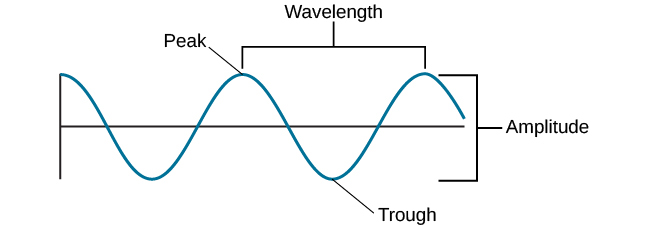

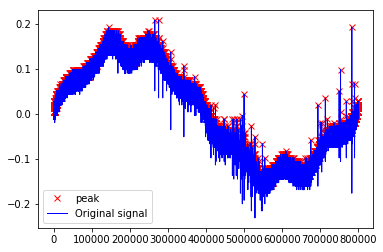

In [12]:
from scipy.signal import find_peaks
#This function takes a one-dimensional array and finds all local maxima by simple comparison of neighbouring values. Optionally, 
#a subset of these peaks can be selected by specifying conditions for a peak’s properties.
x = good_sig
peaks, _ = find_peaks(x)
plt.plot(peaks, x[peaks], "rx", label='peak')
plt.plot(x,'b-', linewidth=1 ,label='Original signal')
plt.legend()

Sorry for my poor understand, and my poor English. 
Three-phase electric power is a common method of alternating current electric power generation, transmission, and distribution.

**Features:**
1. The phase currents tend to cancel out one another, summing to zero in the case of a linear balanced load.By applying Kirchhoff's voltage law to the neutral node, the three phase currents sum to the total current in the neutral line. In the balanced case: V1 + V2 + V3 = 0 
2. If Three-phase electric power is in the balanced case: V1peak = V2peak = V3peak
3. In the balanced case, the phase(rad) between each Wave will be close to 120 square. Just like figure2.
4.



**Figure 1:**
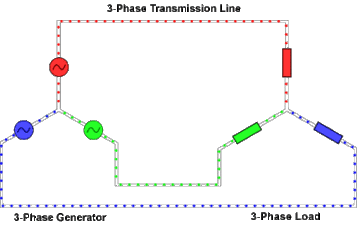

**Figure 2:**
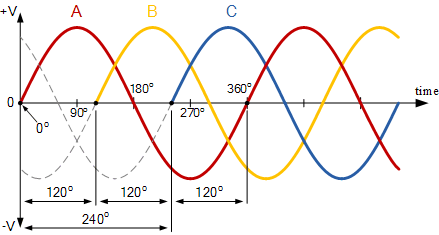

2.8309774278069235


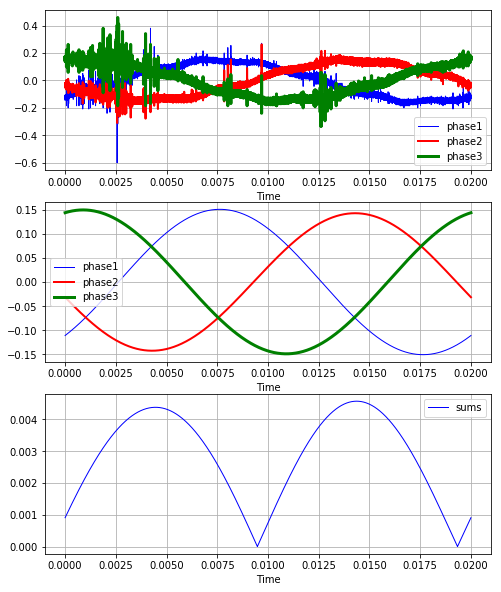

In [13]:
#Example of Phase1, phase2, phase3
phase1 = min_max(pf_train_v[3, :])
phase2 = min_max(pf_train_v[4, :])
phase3 = min_max(pf_train_v[5, :])

_, phase1_sig_fft = FourierTransform(phase1)
_, phase2_sig_fft = FourierTransform(phase2)
_, phase3_sig_fft = FourierTransform(phase3)
filter_phase1_sig, _ = bandpassfilter(phase1_sig_fft, sample_freq, lowcut, highcut)
filter_phase2_sig, _ = bandpassfilter(phase2_sig_fft, sample_freq, lowcut, highcut)
filter_phase3_sig, _ = bandpassfilter(phase3_sig_fft, sample_freq, lowcut, highcut)

plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(time_vec, phase1,'b-', linewidth=1 ,label='phase1')
plt.plot(time_vec, phase2,'r-', linewidth=2 ,label='phase2')
plt.plot(time_vec, phase3,'g-', linewidth=3 ,label='phase3')
plt.xlabel('Time')
#plt.title('good sig')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(312)
plt.plot(time_vec, filter_phase1_sig,'b-', linewidth=1 ,label='phase1')
plt.plot(time_vec, filter_phase2_sig,'r-', linewidth=2 ,label='phase2')
plt.plot(time_vec, filter_phase3_sig,'g-', linewidth=3 ,label='phase3')
plt.xlabel('Time')
#plt.title('good sig')
plt.legend(loc='best')
plt.grid(True)

sums = abs(filter_phase1_sig + filter_phase2_sig + filter_phase3_sig)
zeros = np.zeros_like(sums)
ds  = distance.euclidean(np.zeros_like(sums), sums)
print(ds)

plt.subplot(313)
plt.plot(time_vec, sums,'b-', linewidth=1 ,label='sums')
plt.xlabel('Time')
#plt.title('good sig')
plt.legend(loc='best')
plt.grid(True)


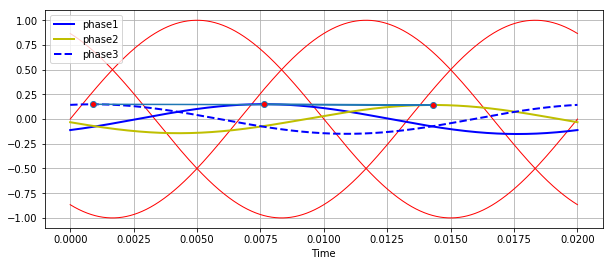

In [14]:
from math import pi
from scipy.signal import find_peaks

Ea = np.sin(2*pi*50*time_vec) 
Eb = np.sin(2*pi*50*time_vec - 2*pi/3)
Ec = np.sin(2*pi*50*time_vec - 4*pi/3)

#print(E_peak)
peaks1, _ = find_peaks(filter_phase1_sig)
peaks2, _ = find_peaks(filter_phase2_sig)
peaks3, _ = find_peaks(filter_phase3_sig)

peak1_num = filter_phase1_sig[peaks1]
peak2_num = filter_phase2_sig[peaks2]
peak3_num = filter_phase3_sig[peaks3]
peak = np.concatenate((peaks1, peaks2, peaks3))
peak_num = abs(np.concatenate((peak1_num, peak2_num, peak3_num)))

#print(abs(E_peak_num / np.sqrt(2) - peak_num))

plt.figure(figsize=(10,4))
#plt.subplot(311)
plt.plot(time_vec, Ea , 'r-', linewidth=1)
plt.plot(time_vec, Eb ,'r-', linewidth=1)
plt.plot(time_vec, Ec ,'r-', linewidth=1)
plt.plot(time_vec, filter_phase1_sig,'b-', linewidth=2,label='phase1')
plt.plot(time_vec, filter_phase2_sig,'y-', linewidth=2,label='phase2')
plt.plot(time_vec, filter_phase3_sig,'b--', linewidth=2,label='phase3')
plt.plot(time_vec[peak], peak_num, marker='o', mfc='r')
plt.xlabel('Time')
plt.legend(loc='best')
plt.grid(True)

In [15]:
#print(time_vec[np.isclose(filter_phase1_sig, 0.0)])
def phase_radian(data):
    x = np.arcsin(np.max(data))
    t = time_vec[np.where(data == np.max(data))]
    
    return np.rad2deg(2*pi*t*50-abs(x))

x1 = phase_radian(filter_phase1_sig)
x2 = phase_radian(filter_phase2_sig)
x3 = phase_radian(filter_phase3_sig)
test  = sorted([x1, x2, x3])

for i, x in enumerate(test):
    if i == len(test)-1: break;
    print(test[i+1]-x)
#print(np.deg2rad(120))

[121.25373765]
[120.42399024]


In [16]:
class make_features(object):
    
    def create(self, signal_id, data):
        
        all_features = []
        extend_features = []
        
        phase1 = min_max(data[signal_id, :]) #Normalize Data to 0
        phase2 = min_max(data[signal_id+1, :])
        phase3 = min_max(data[signal_id+2, :])
           
        phase1_radian = phase_radian(phase1)
        phase2_radian = phase_radian(phase2)
        phase3_radian = phase_radian(phase3)   
        radians       = sorted([phase1_radian[0], phase2_radian[0], phase3_radian[0]])
        
        phase1_e = self.max_calculate(phase1)
        phase2_e = self.max_calculate(phase2)
        phase3_e = self.max_calculate(phase3)
        
        sums= abs(phase1+ phase2 + phase3) # V1 + V2 + V3 = 0
        sums_mean = np.mean(sums)
        sums_std  = np.std(sums) 
        
        extend_features.append(sums_mean)
        extend_features.append(sums_std)
        extend_features.append(abs(phase1_e - phase2_e))
        extend_features.append(abs(phase2_e - phase3_e))
        extend_features.append(abs(phase1_e - phase3_e))
        for i, rad in enumerate(radians):
            if i == len(radians)-1: break; 
            extend_features.append(radians[i+1]-rad)
        
        for phase in [phase1, phase2, phase3]:
            
            mean        = phase.mean()
            std         = phase.std()
            std_top     = mean + std 
            std_bottom  = mean - std
            cv          = std / mean 
            max_v       = np.max(phase)
            min_v       = np.min(phase) 
            max_min_v   = max_v-min_v
            
            all_features.append(mean)
            all_features.append(std)
            all_features.append(std_top)
            all_features.append(std_bottom)
            all_features.append(cv)
            all_features.append(max_v)
            all_features.append(max_min_v)
        
        all_features.extend(extend_features)
        
        return all_features
    
    def max_calculate(self, data):
        return np.max(data)

In [17]:
maker = make_features()

def pre_data(start_index,end_index):
    all_features = []
    train_target = []
    for i in tqdm(range(start_index,end_index, 3)):
        #test = meta_train[meta_train.signal_id == i].target.values[0]
        train_target.append(meta_train[meta_train.signal_id == i].target.values[0])
        if i== len(meta_train): break
        features = maker.create(i, pf_train_v)
        all_features.append(features) 
    
    return all_features, train_target
    
X , y = pre_data(0, len(meta_train))

100%|██████████| 2904/2904 [02:05<00:00, 23.22it/s]


In [18]:
X = np.asarray(X)
columns = []
for i in range(X.shape[1]): columns.append('feature {}'.format(i))

#X.shape
features_df = pd.DataFrame(X[:,:30], columns=columns)
features_df['target'] = y
#print(features_df.head())
features_df.to_csv("features_train.csv", index=False)
#features_df["feature 25"] = features_df["feature 25"].apply(lambda x: x[0])
#features_df["feature 26"] = features_df["feature 26"].apply(lambda x: x[0])
print(features_df.head())

   feature 0  feature 1  feature 2   ...    feature 26  feature 27  target
0  -0.003610   0.108790   0.105180   ...     97.513820  132.319005       0
1  -0.003901   0.107244   0.103343   ...      2.457279  137.243180       1
2  -0.005068   0.110308   0.105239   ...    144.185576  112.570243       0
3  -0.006742   0.123173   0.116431   ...      0.000450  207.792895       0
4  -0.004008   0.107833   0.103825   ...     53.357400   53.689334       0

[5 rows x 29 columns]


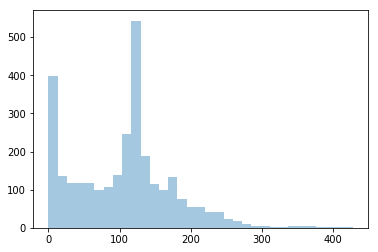

In [19]:
sns.distplot(features_df['feature 27'].values, kde=False)

In [20]:
ss = StandardScaler()
#Normailize Data
X_INPUT = ss.fit_transform(X)
print(X_INPUT.shape)

x_train, x_test, y_train, y_test = train_test_split(X_INPUT,y,
                                                    test_size=0.2,
                                                    random_state=2019)

(2904, 28)


In [21]:
#For figuring out the feature Importance
#I try to Use RandomForestClassifier
#To Pick up feastures

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

clss = GradientBoostingClassifier(n_estimators=100, random_state=2019)
clss.fit(x_train, y_train)
y_pred = clss.predict(x_test)
print('matthews_corrcoef:{}'.format(metrics.matthews_corrcoef(y_test, y_pred))) # Just Test.
print('Accuracy(test) : %.5f' %metrics.accuracy_score(y_test, y_pred))

matthews_corrcoef:0.6256588307404086
Accuracy(test) : 0.95525


freature importance
	feature 0            : 0.029778
	feature 1            : 0.007577
	feature 2            : 0.075783
	feature 3            : 0.024883
	feature 4            : 0.166347
	feature 5            : 0.015419
	feature 6            : 0.039324
	feature 7            : 0.006758
	feature 8            : 0.020870
	feature 9            : 0.057702
	feature 10           : 0.023715
	feature 11           : 0.047036
	feature 12           : 0.011052
	feature 13           : 0.024762
	feature 14           : 0.005558
	feature 15           : 0.047805
	feature 16           : 0.115234
	feature 17           : 0.016329
	feature 18           : 0.012418
	feature 19           : 0.021543
	feature 20           : 0.058224
	feature 21           : 0.056959
	feature 22           : 0.053719
	feature 23           : 0.012109
	feature 24           : 0.017509
	feature 25           : 0.004205
	feature 26           : 0.021503
	feature 27           : 0.005878


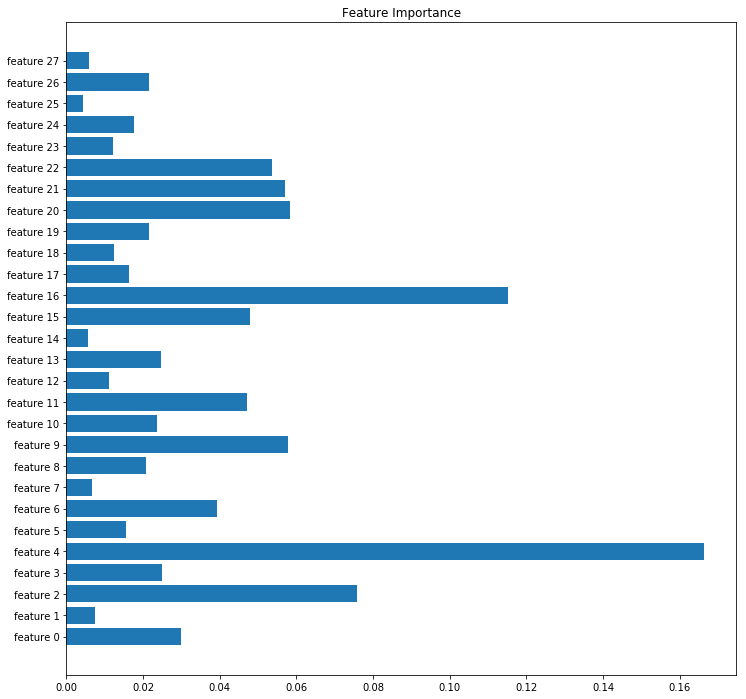

In [22]:
fti = clss.feature_importances_

print('freature importance')
for i, feat in enumerate(columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

left = range(len(columns))
high = fti

plt.figure(figsize=(12, 12))
plt.barh(left, high)
plt.yticks(range(len(columns)),columns)
plt.title("Feature Importance")
plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV

grid_param = { 'learning_rate':[0.1, 0.01, 0.001], 
              'n_estimators': [100, 200, 300], 
                     'max_features': [1, 'auto', None], 
                     'max_depth': [1, 5, 10, None], 
                     'min_samples_leaf': [1, 2, 4,] } 
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=2019), grid_param, cv=10 ) 
grid_search.fit(x_train, y_train) 


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 200, 300], 'max_features': [1, 'auto', None], 'max_depth': [1, 5, 10, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
print('best performance:{}'.format(grid_search.best_score_)) 
print('best estimater:{}'.format(grid_search.best_params_))

best performance:0.9621179509255273
best estimater:{'learning_rate': 0.1, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 4, 'n_estimators': 100}


In [25]:
y_pred = grid_search.predict(x_test) 
print('matthews_corrcoef:{}'.format(metrics.matthews_corrcoef(y_test, y_pred))) # Just Test. 
print('Accuracy(test) : %.5f' %metrics.accuracy_score(y_test, y_pred))

matthews_corrcoef:0.5512879236018063
Accuracy(test) : 0.95009


In [26]:
del pf_train_v
del X_INPUT
gc.collect()

4964

In [27]:
meta_test = pd.read_csv('../input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

,id_measurement,phase
signal_id,,
8712,2904,0
8713,2904,1
8714,2904,2
8715,2905,0
8716,2905,1


In [28]:
first_sig = meta_test.index[0]
n_parts = 9
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)
start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []

8712 9 20337 2259 6 20337
[[8712, 10971], [10971, 13230], [13230, 15489], [15489, 17748], [17748, 20007], [20007, 22266], [22266, 24525], [24525, 26784], [26784, 29043], [29043, 29049]]


In [29]:
test_all_features = []
maker = make_features()

for start, end in start_end:
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    subset_test = subset_test.T.values
    for i in tqdm(range(0, subset_test.shape[0], 3)):
        if i == subset_test.shape[0]: break
        features = maker.create(i, subset_test)
        test_all_features.append(features)

X_TEST =  np.asarray(test_all_features)
X_TEST = ss.transform(X_TEST)
del subset_test
gc.collect()

100%|██████████| 2/2 [00:00<00:00, 25.28it/s]


14

In [30]:
X_TEST.shape
print(X_TEST)

[[-0.185166   -0.60389496 -0.76503602 ... -0.41782064  0.49766271
  -0.00624936]
 [ 1.78519679 -0.34165164  0.50998077 ... -0.41782064  0.59765299
   0.75510012]
 [-0.5472491  -0.17831567 -0.47161574 ... -0.56212119  0.7500211
   0.01958684]
 ...
 [ 1.85413398 -0.3307685   0.55649238 ... -0.63427146  0.70589519
   0.08247067]
 [-0.19901085 -0.15388537 -0.27068577 ... -0.41782064 -0.21141727
   0.97157081]
 [ 1.9588491  -0.09655244  0.86961778 ... -0.48997092  0.53873032
  -0.3461807 ]]


In [31]:
TEST_PRED   = grid_search.predict(X_TEST)
WHERE_FAULT = np.where(TEST_PRED == 1)

In [32]:
submission = pd.read_csv('../input/sample_submission.csv')
print(len(submission))
submission.head()

20337


,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [33]:
print(WHERE_FAULT) 

#FIRST TIME SUBMISSION
OUTPUT = []
for ANS in tqdm(TEST_PRED): 
    if ANS == 0: 
        OUTPUT.extend([0, 0, 0])
    else: 
        OUTPUT.extend([1, 1, 1])
print(len(OUTPUT))

100%|██████████| 6779/6779 [00:00<00:00, 1057270.92it/s]

(array([  63,   68,   95,  144,  245,  276,  365,  416,  425,  454,  473,
        512,  552,  693,  707,  818,  906,  937,  946, 1041, 1048, 1063,
       1087, 1245, 1457, 1473, 1544, 1590, 1631, 1712, 1716, 1733, 1760,
       1784, 1888, 1970, 1995, 1998, 2115, 2238, 2353, 2513, 2521, 2609,
       2669, 2690, 2828, 2887, 2913, 2933, 2991, 3079, 3087, 3094, 3152,
       3239, 3402, 3484, 3743, 3757, 3861, 4058, 4060, 4240, 4256, 4294,
       4463, 4592, 4787, 4853, 4925, 4942, 4952, 4980, 5074, 5155, 5292,
       5300, 5428, 5456, 5469, 5501, 5589, 5646, 5647, 5719, 5827, 5830,
       5854, 6127, 6313, 6451, 6512, 6552, 6632, 6659, 6763, 6774]),)
20337


In [34]:
submission['target'] = OUTPUT
submission.head()
#submission.to_csv('submission.csv', index=False)

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [35]:
submission.to_csv('submission.csv', index=False)